## 7.CFSFDP
#### Clustering by Fast Search and Find of Density Peaks

In [ ]:
!git clone https://github.com/rhfo3218/LG_ML_tutorial.git
import os
os.chdir('/content/LG_ML_tutorial/7. CFSFDP')

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance_matrix

#### (1) dataset

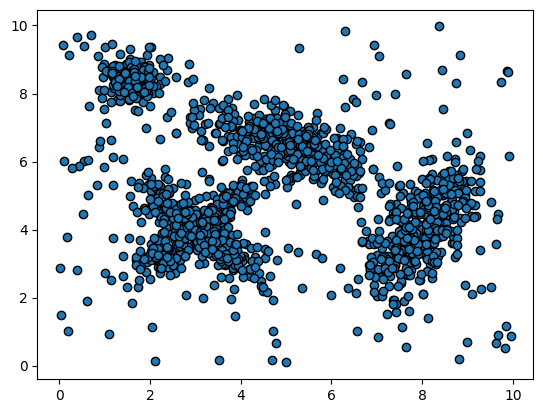

In [8]:
data = pd.read_csv("example_data.csv")
plt.scatter(data.V1, data.V2, edgecolors='black')
plt.show()

#### (1) implementation CFSFDP : Find dc

In [42]:
def find_dc(data, per=0.015):
    n = data.shape[0]
    nper = int(round(n*per,0))
    nbrs = NearestNeighbors(n_neighbors=nper, algorithm='kd_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)
    return np.array(distances)[:,(nper-1)].mean()

dc = find_dc(data)

0.42901573950695465

##### recommended dc for dataset

In [54]:
dc

0.42901573950695465

#### (2) implementation CFSFDP : decision graph

In [44]:
def decision_graph(data, dc):
    n = data.shape[0]
    dist = np.array(distance_matrix(data.values, data.values))

    dist_tmp = np.exp((dist/dc)*(dist/dc) * -1)

    rho = dist_tmp.mean(0)

    order_rho = np.argsort(rho)[::-1]

    delta = np.zeros(n)
    delta[order_rho[0]] = dist[order_rho[0],:].max()

    for i in range(1,n):
        delta[order_rho[i]] = min(dist[order_rho[i],order_rho[0:i]])

    gamma = rho * delta


    return delta, gamma, rho

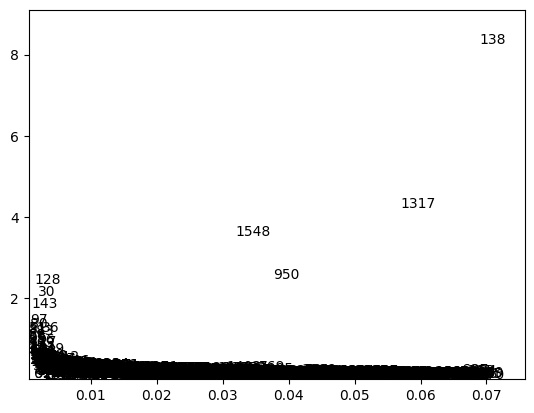

In [47]:
delta, gamma, rho = decision_graph(data, dc)
for i in range(0,data.shape[0]):
    plt.text(rho[i], delta[i], str(i))
plt.xlim([min(rho), max(rho)*1.1])
plt.ylim([min(delta), max(delta)*1.1])
plt.show()

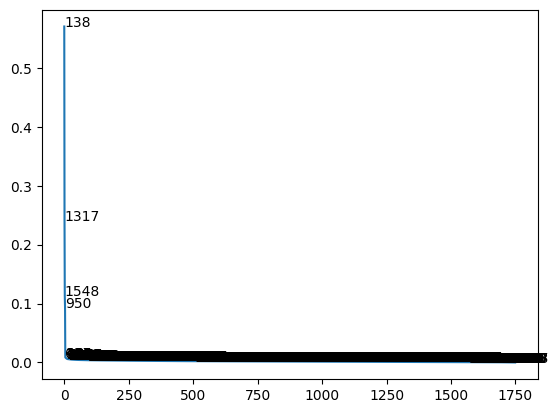

In [49]:
order_gamma = np.argsort(gamma)[::-1]
plt.plot(gamma[order_gamma])
for i in range(0,data.shape[0]):
    plt.text(i, gamma[order_gamma][i], str(order_gamma[i]))
plt.show()

##### density peak indices

In [53]:
peak_index = [138, 1317, 1548, 950]

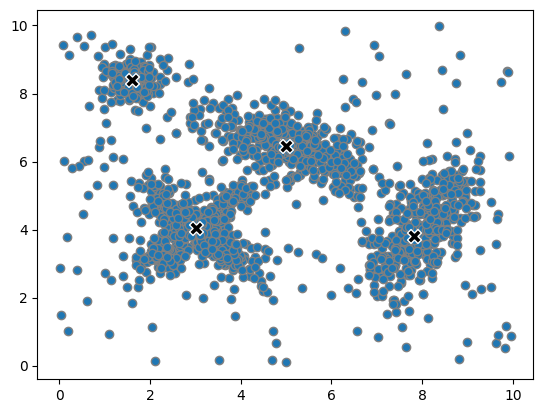

In [52]:
plt.scatter(data.V1, data.V2, edgecolors='grey')
plt.scatter(data.V1[order_gamma[0:4]], data.V2[order_gamma[0:4]],
            color = 'black', marker='X', edgecolors='white', s=100)
plt.show()

#### (3) implementation CFSFDP : assign

In [55]:
def assign(data, peak_index, rho):
    n = data.shape[0]
    cluster_res = np.full(n,-1)
    cluster_res[peak_index] = peak_index

    dist = np.array(distance_matrix(data.values, data.values))

    order_rho = np.argsort(rho)[::-1]
    for i in range(0,n):
        i_idx = order_rho[i]
        if cluster_res[i_idx] == -1:
            label_info = order_rho[0:i][dist[i_idx,order_rho[0:i]].argmin()]
            cluster_res[i_idx] = cluster_res[label_info]
    label, counts = np.unique(cluster_res, return_counts=True)
    dict(zip(label, counts))

    return cluster_res

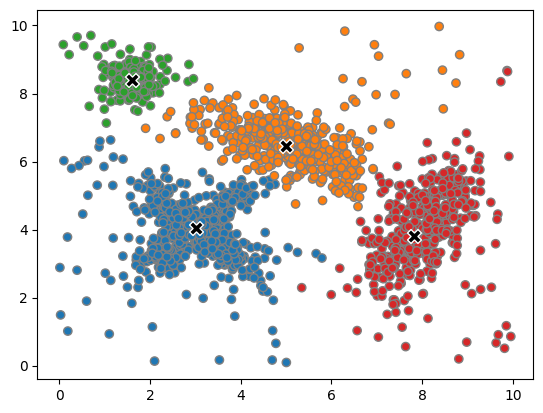

In [64]:
cluster_res = assign(data, peak_index, rho)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c',
          '#d62728', '#9467bd', '#8c564b',
          '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'][0:len(np.unique(cluster_res))]
color_dict = dict(zip(np.unique(cluster_res), colors))

plt.scatter(data.V1, data.V2, edgecolors='grey', color = [color_dict[x] for x in cluster_res])
plt.scatter(data.V1[peak_index], data.V2[peak_index],
            color = 'black', marker='X', edgecolors='white', s=100)
plt.show()

#### (4) implementation CFSFDP : noise removal

In [60]:
def outlier_border(data, cluster_res, dc, rho):
    n = data.shape[0]
    dist = np.array(distance_matrix(data.values, data.values))
    is_border = cluster_res.copy()
    for i in range(0,n):
        diff_cluster_idx = np.where(cluster_res != cluster_res[i])
        if np.min(dist[i,diff_cluster_idx]) <= dc:
            is_border[i] = is_border[i]* -1

    is_noise = cluster_res.copy()
    for j in np.unique(cluster_res):
        if sum(is_border == j*(-1)) > 0:
            border_j_idx = np.where(is_border == j*(-1))
            max_rho_border = max(rho[border_j_idx])
            is_noise[(rho <= max_rho_border) & (cluster_res == j)] = -1 * j

    return is_border, is_noise

In [61]:
is_border, is_noise = outlier_border(data, cluster_res, dc, rho)

##### border instances

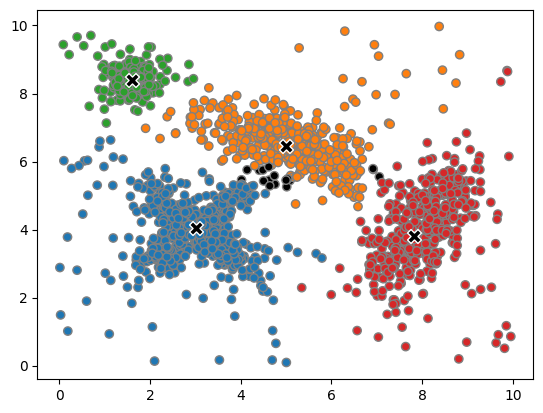

In [67]:
colors = np.array([color_dict[x] for x in cluster_res])
colors[is_border<0] = "#000000"

plt.scatter(data.V1, data.V2, edgecolors='grey', color = colors)
plt.scatter(data.V1[peak_index], data.V2[peak_index],
            color = 'black', marker='X', edgecolors='white', s=100)
plt.show()

##### noise removal

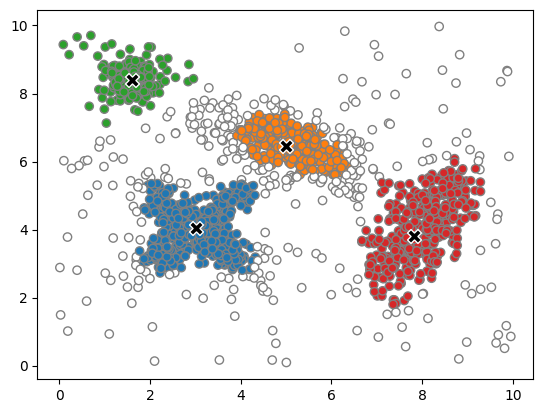

In [68]:
colors = np.array([color_dict[x] for x in cluster_res])
colors[is_noise<0] = "#FFFFFF"

plt.scatter(data.V1, data.V2, edgecolors='grey', color = colors)
plt.scatter(data.V1[peak_index], data.V2[peak_index],
            color = 'black', marker='X', edgecolors='white', s=100)
plt.show()